# Credit Card Default Risk Modeling: PD Estimation & Model Evaluation

## Objective
Estimate Probability of Default (PD) for credit card customers using demographic,
behavioral, and financial attributes. 

## Use Cases
- Credit risk decisioning
- Portfolio monitoring
- Early risk identification

## Target Variable
Default payment next month (1 = Default, 0 = Non-default)


### 1. Import Libraries

In [76]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve, 
    confusion_matrix,
    classification_report
)

# Survival Analysis
#from lifelines import KaplanMeierFitter, CoxPHFitter

# Stability / Monitoring
from scipy.stats import ks_2samp


### 2. Load the Dataset

In [4]:
df = pd.read_csv("Credit_Card_Default.csv")
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
df.shape

(30000, 25)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [11]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [13]:
df.isnull().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

### 3. Data Quality Checks & Preprocessing
   -  Remove ID, Rename Target Column

In [16]:
df = df.drop(columns=['ID'])
df.rename(columns={ 'default payment next month': "DEFAULT"}, inplace=True)
print(df.shape)
df.head()

(30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


 - Analyzing the class distribution

In [19]:
class_counts = df['DEFAULT'].map({0: 'No', 1: 'Yes'}).value_counts() # insert code here 
print("Class Distribution:")
print(class_counts)

Class Distribution:
DEFAULT
No     23364
Yes     6636
Name: count, dtype: int64


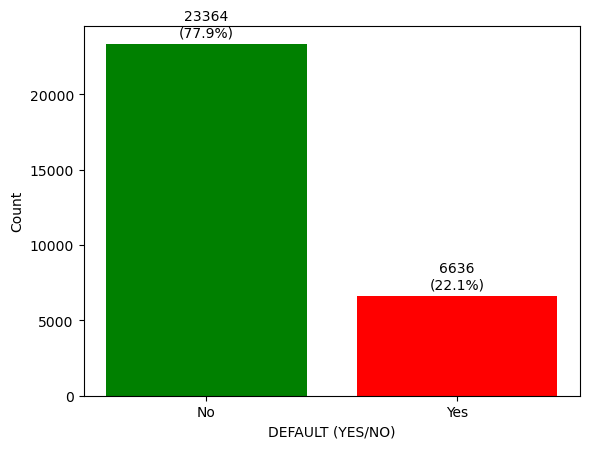

In [140]:
# Visualize the class distribution
#plt.figure(figsize=(12, 10))
#plt.bar(class_counts.index, class_counts.values, color='skyblue')
bars = plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
#plt.title('Class Distribution (DEFAULT)')
plt.xlabel("DEFAULT (YES/NO)")
plt.ylabel('Count')

# --- Adding Annotations (Counts and Percentages) ---
total = len(df)
for bar in bars:
    height = bar.get_height()
    percentage = f'{height / total * 100:.1f}%'
    
    # Format the annotation text
    annotation_text = f'{height}\n({percentage})'
    
    # Add the text label on top of each bar
    plt.annotate(
        annotation_text,
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset
        textcoords="offset points",
        ha='center',    # Center horizontally
        va='bottom',    # Align vertically at the bottom of the text block
        fontsize=10
    )

plt.show()

### 3. Categorical Encoding

In [24]:
df["SEX"] = df["SEX"].map({1: "Male", 2: "Female"})
df = pd.get_dummies(df, columns=["SEX", "EDUCATION", "MARRIAGE"], drop_first=True)

In [26]:
print(df.shape)
df.head()

(30000, 31)


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_Male,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,False,False,True,False,False,False,False,True,False,False
1,120000,26,-1,2,0,0,0,2,2682,1725,...,False,False,True,False,False,False,False,False,True,False
2,90000,34,0,0,0,0,0,0,29239,14027,...,False,False,True,False,False,False,False,False,True,False
3,50000,37,0,0,0,0,0,0,46990,48233,...,False,False,True,False,False,False,False,True,False,False
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,True,False,True,False,False,False,False,True,False,False


### 4. Feature Engineering

#### 4.1 Payment Behavior (Delinquency)
Payment history is the strongest predictor of default in consumer credit.
The variables PAY_0 to PAY_6 capture monthly delinquency states, but raw month-by-month values are noisy.

Risk interpretation:

RECENT_DELINQ = 0 or -1 → low short-term risk

RECENT_DELINQ ≥ 1 → elevated near-term default risk

In [30]:

pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']

df['MAX_DELINQ'] = df[pay_cols].max(axis=1) # Historical severity
df['AVG_DELINQ'] = df[pay_cols].mean(axis=1) # Behavioral consistency

# The most recent repayment status -- How late the customer was last month--> Short-term default pressure
df['RECENT_DELINQ'] = df['PAY_0']


#### 4.2 Billing & Payment Behavior

Payment Ratio Interpretation:

≥ 1.0	  --     Pays full balance (very low risk)

0.5–1.0	  --    Partial but reasonable payment

< 0.5	  --     Financial stress

~0	      --     Severe default risk

In [33]:
# Billing & Payment Behavior
bill_cols = [
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3',
    'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'
]

pay_amt_cols = [
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3',
    'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'
]

df['AVG_BILL_AMT'] = df[bill_cols].mean(axis=1) # Exposure magnitude
df['AVG_PAY_AMT'] = df[pay_amt_cols].mean(axis=1) # Repayment capacity

# How much of what I owe do I actually pay? -- Willingness & ability
df['PAYMENT_RATIO'] = df['AVG_PAY_AMT'] / (df['AVG_BILL_AMT'] + 1) 

# How much of available credit is being used? -- Credit stress
df['UTILIZATION'] = df['AVG_BILL_AMT'] / (df['LIMIT_BAL'] + 1)


In [35]:
df.shape

(30000, 38)

In [37]:
df.head()


,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,MAX_DELINQ,AVG_DELINQ,RECENT_DELINQ,AVG_BILL_AMT,AVG_PAY_AMT,PAYMENT_RATIO,UTILIZATION
0,20000,24,2,2,-1,-1,-2,-2,3913,3102,...,True,False,False,2,-0.333333,2,1284.000000,114.833333,0.089364,0.064197
1,120000,26,-1,2,0,0,0,2,2682,1725,...,False,True,False,2,0.500000,-1,2846.166667,833.333333,0.292689,0.023718
2,90000,34,0,0,0,0,0,0,29239,14027,...,False,True,False,0,0.000000,0,16942.166667,1836.333333,0.108382,0.188244
3,50000,37,0,0,0,0,0,0,46990,48233,...,True,False,False,0,0.000000,0,38555.666667,1398.000000,0.036258,0.771098
4,50000,57,-1,0,-1,0,0,0,8617,5670,...,True,False,False,0,-0.333333,-1,18223.166667,9841.500000,0.540025,0.364456


### 5. Split the Dataset

In [40]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['DEFAULT'])
y = df['DEFAULT']

x_train, x_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


### Impute Before Scaling & SMOTE

In [43]:
# Median Imputation
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed  = imputer.transform(x_test)


### 6. Standardize features (feature scaling)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train_imputed)
x_test_scaled = scaler.transform(x_test_imputed)


### 7. Apply SMOTE to the training data

In [49]:
 # Import SMOTE
#!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE

In [51]:
#np.isnan(x_train).sum()

In [53]:
# Apply SMOTE to the training data
smote = SMOTE(sampling_strategy=1.0,random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train_scaled, y_train)

In [55]:
print(x_train_smote.shape)
print(y_train_smote.shape)

(37382, 37)
(37382,)


### 8. Visualizing class distribution after SMOTE

Before SMOTE:
DEFAULT
0    18691
1     5309
Name: count, dtype: int64

After SMOTE:
DEFAULT
0    18691
1    18691
Name: count, dtype: int64


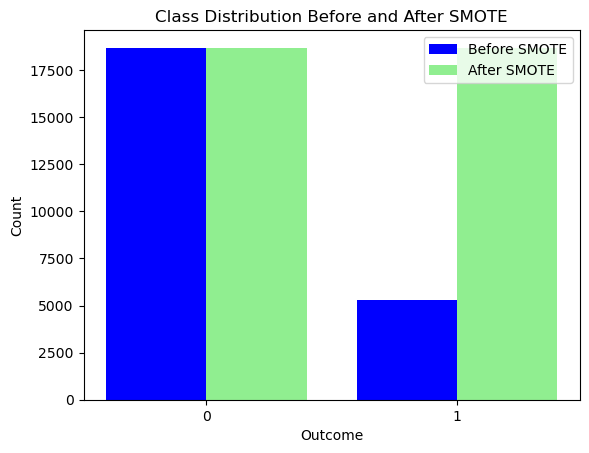

In [58]:
# Check the new class distribution
print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_smote.value_counts())

# Visualize the new class distribution
counts_before = y_train.value_counts()
counts_after = y_train_smote.value_counts()

plt.bar([0, 1], [counts_before.get(0, 0), counts_before.get(1, 0)], width=0.4, label='Before SMOTE', color='blue')
plt.bar([0.4, 1.4], [counts_after.get(0, 0), counts_after.get(1, 0)], width=0.4, label='After SMOTE', color='lightgreen')

plt.title('Class Distribution Before and After SMOTE')
plt.xlabel('Outcome')
plt.ylabel('Count')
plt.xticks([0.2, 1.2], ['0', '1'])
plt.legend()
plt.show()

### 9. Initialize the logistic regression models

In [61]:
from sklearn.linear_model import LogisticRegression

In [63]:
# Initialize the models
model_orig = LogisticRegression(solver='liblinear', max_iter=1000)
model_smote = LogisticRegression(solver='liblinear', max_iter=1000)

### 10. Train the models

In [66]:
# Train the model on original data
model_orig.fit(x_train_scaled, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [68]:
# Train the model on SMOTE data
model_smote.fit(x_train_smote, y_train_smote) 

LogisticRegression(max_iter=1000, solver='liblinear')

### 10. Make predictions and prepare to evaluate models 

In [71]:
# Make predictions on the test set
y_pred_orig = model_orig.predict(x_test_scaled)
y_pred_smote = model_smote.predict(x_test_scaled)

# Predictions probability for ROC-AUC
y_prob_orig = model_orig.predict_proba(x_test_scaled)[:, 1]
y_prob_smote = model_smote.predict_proba(x_test_scaled)[:, 1]

# Evaluate the model's performance
def evaluate_model(y_test, y_pred, y_prob):
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print("Precision:", round(precision_score(y_test, y_pred), 4))
    print("Recall:", round(recall_score(y_test, y_pred), 4))
    print("ROC-AUC:", round(roc_auc_score(y_test, y_prob), 4))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

### 11. Evaluate the model on original data.

In [78]:
print("Performance on Original Data:")
evaluate_model(y_test, y_pred_orig, y_prob_orig)

Performance on Original Data:
Accuracy: 0.8082
Precision: 0.6938
Recall: 0.2374
ROC-AUC: 0.7263

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.76      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000



### 12. Evaluate the model on SMOTE-augmented data

In [81]:
print("Performance on SMOTE Augmented Data:")
evaluate_model(y_test, y_pred_smote, y_prob_smote)

Performance on SMOTE Augmented Data:
Accuracy: 0.7112
Precision: 0.4039
Recall: 0.6428
ROC-AUC: 0.7286

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.73      0.80      4673
           1       0.40      0.64      0.50      1327

    accuracy                           0.71      6000
   macro avg       0.64      0.69      0.65      6000
weighted avg       0.77      0.71      0.73      6000



### 13. Visualize and compare model performance
ROC curves plot the true positive rate (sensitivity) against the false positive rate (1-specificity) for different classification thresholds. 

They help you understand how well each model distinguishes between the two classes (default and non-default) across various levels of sensitivity and specificity. 

The provided code generates ROC curves for both the original and SMOTE-augmented models, allowing you to visually compare their performance and assess the impact of SMOTE on the model's ability to discriminate between the classes.


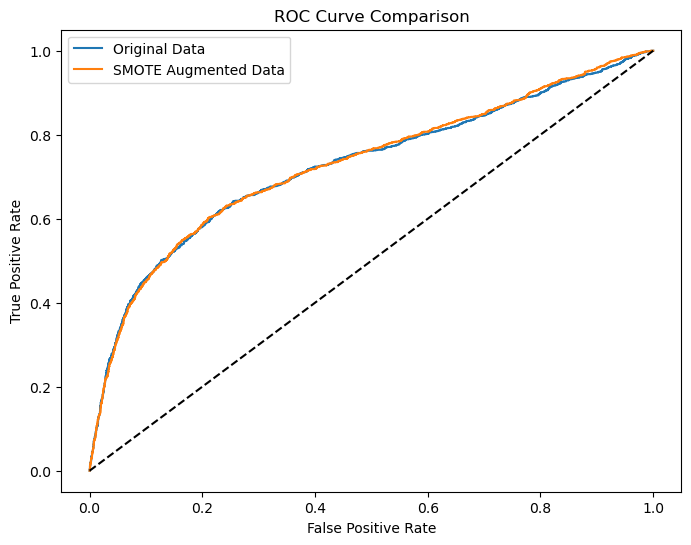

In [83]:
# Plot ROC curves
fpr_orig, tpr_orig, _ = roc_curve(y_test, y_prob_orig)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_prob_smote)

plt.figure(figsize=(8, 6))
plt.plot(fpr_orig, tpr_orig, label='Original Data')
plt.plot(fpr_smote, tpr_smote, label='SMOTE Augmented Data')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()

In [85]:
from sklearn.metrics import roc_auc_score
from scipy.stats import ks_2samp

In [97]:
# ROC–AUC & KS
auc_orig = roc_auc_score(y_test, y_prob_orig)
ks_orig = ks_2samp(
    y_prob_orig[y_test == 1],
    y_prob_orig[y_test == 0]
).statistic

print("AUC_orig:", round(auc_orig, 4))
print("KS_orig:", round(ks_orig,4))

AUC_orig: 0.7263
KS_orig: 0.3885


In [101]:
# ROC–AUC & KS
auc_smote = roc_auc_score(y_test, y_prob_smote)
ks_smote = ks_2samp(
    y_prob_smote[y_test == 1],
    y_prob_smote[y_test == 0]
).statistic

print("AUC_smote:", round(auc_smote,4))
print("KS_smote:", round(ks_smote, 4))

AUC_smote: 0.7286
KS_smote: 0.3912


### 14. Performance Observations on Original (Imbalanced) Data:
   - Key metrics:

     Accuracy: 0.81

    Precision (Default = 1): 0.69

    Recall (Default = 1): 0.24

    ROC–AUC: 0.73

  - The model achieves high overall accuracy, driven primarily by strong performance on the non-default (majority) class.

  - Recall for defaulters is low (23.7%), indicating the model misses a large portion of true defaults.

  - Precision for defaulters is relatively high, meaning when the model predicts default, it is often correct.

  - ROC–AUC suggests moderate discriminatory power, but class imbalance limits practical usefulness.

- Interpretation (Credit Risk Context):

  - This model is conservative and biased toward predicting non-default.

  - While acceptable for general ranking, it is not suitable for default risk identification, as many high-risk borrowers are not flagged.

### 15. Performance Observations on SMOTE-Augmented (Balanced) Data: 
  
  - Key metrics:

      Accuracy: 0.71

      Precision (Default = 1): 0.40

      Recall (Default = 1): 0.64

      ROC–AUC: 0.73
      
   - Accuracy decreases, which is expected after balancing the dataset.

   - Recall improves substantially (from ~24% → ~64%), meaning the model now captures a majority of true defaulters.

   - Precision declines, indicating an increase in false positives.

   - ROC–AUC remains stable, suggesting the model’s ranking ability is preserved.

   - Interpretation (Credit Risk Context):

     - The SMOTE-trained model is risk-sensitive, prioritizing identification of potential defaulters.

     - Increased false positives are an acceptable trade-off in many lending and risk management scenarios.

     - This model is better aligned with loss prevention, early warning systems, and credit monitoring.

### Comparative Summary (Decision-Oriented)

| Metric | Original Data | SMOTE Data | Interpretation |
| --- | --- | --- | --- |
| Accuracy | Higher | Lower | Accuracy alone is misleading under imbalance |
| Recall | Very Low | High  | SMOTE dramatically improves default detection |
| Precision | Higher | Lower | Trade-off for improved recall |
| ROC-AUC| Similar | Similar | Overall discrimination unchanged |

### 16. Conclusions: Final Model Selection Insight

  - Original model:

    - Better for portfolio-level reporting where false alarms are costly

    - Poor for identifying high-risk borrowers

  - SMOTE model:

    - Better for credit risk decision support, collections prioritization, and stress testing

    - Aligns more closely with regulatory and business objectives focused on risk mitigation